# Aimlytics


Import libraries


In [115]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylab
%matplotlib inline

pylab.rcParams['figure.figsize'] = (15.0, 8.0)

## Image Acquisition and Pre-processing
We want to obtain a clear image, ready to be analyzed.

(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

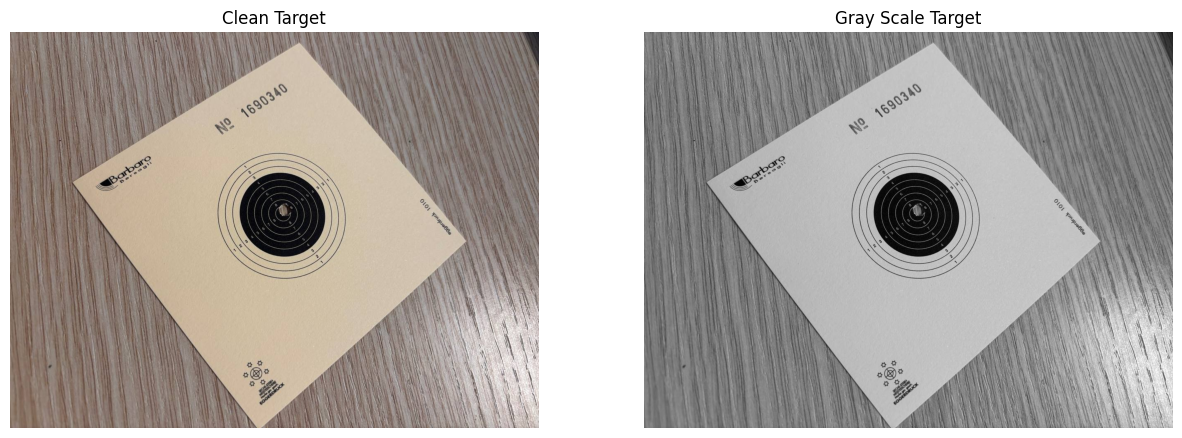

In [116]:
image = cv2.imread("target_images/minimum_error.jpg")

RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


plt.show()
plt.subplot(121)
plt.title("Clean Target")
plt.imshow(RGB_image)
plt.axis('off')
plt.subplot(122)
plt.title("Gray Scale Target")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')


- Filter noise with **GaussianBlur** and **bilateralFilter** filters. The first one reduces noise and softens edges, the second one, particularly useful when working with the detection of circular elements, further reduces noise while preserving important edges.

- Improve Canny edge detection by locally adjusting the threshold. It's useful to enhance contrast and separate bullet holes from the background. Converts the smoothed image into a binary image.

- Remove noise from the binary image with an *opening morphology operation* (a dilation followed by an erosion, image below). It's useful to fill possible gaps in white areas and then remove noise.

![](jupyter_images/opening_opencv_documentation.png)




(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

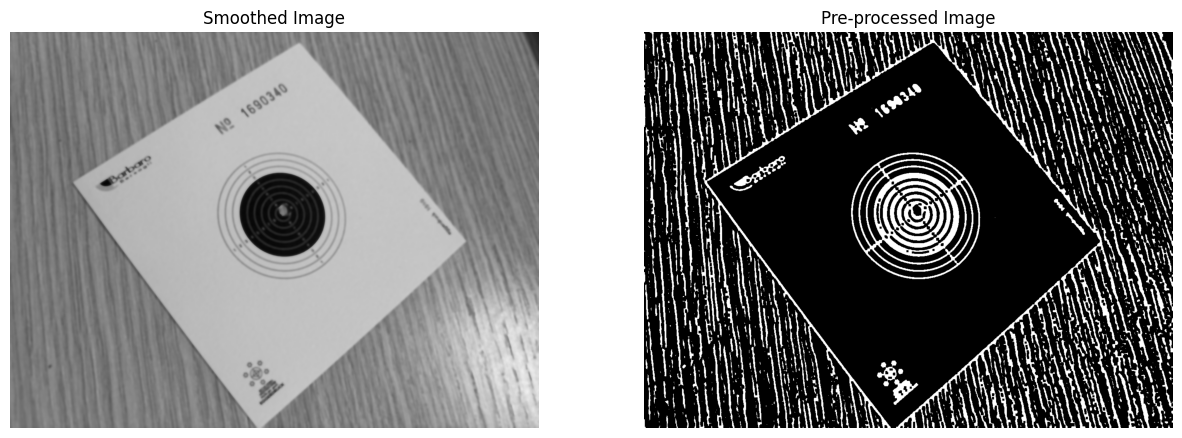

In [117]:
smoothed_image_gauss = cv2.GaussianBlur(gray_image, (5, 5), 0)
# Applied to the grayscale image; 5-by-5 kernel to determine the area of neighboring pixels; 0 to let opencv determine the standard deviation
smoothed_image_bi = cv2.bilateralFilter(smoothed_image_gauss, 9, 75, 75)
# 9-by-9 kernel; 75 for the standard deviations of intensity and spatial filtering


binary_image = cv2.adaptiveThreshold(smoothed_image_bi, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv2.THRESH_BINARY_INV, blockSize=11, C=2)
# ADAPTIVE_THRESH_GAUSSIAN_C to use a Gaussian weighted neighborhood
# THRESH_BINARY_INV inverts the result (white foreground and black background)
# 11 is the region size for the local thresholding; 2 is a constant subtracted from the mean to fine-tune the threshold

kernel = np.ones((3, 3), np.uint8)      # Create a 3-by-3 kernel
cleaned_binary = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel, iterations=2)      # Opening operation applied 2 times

plt.subplot(121)
plt.title("Smoothed Image")
plt.imshow(cv2.cvtColor(smoothed_image_bi,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Pre-processed Image")
plt.imshow(cv2.cvtColor(cleaned_binary,cv2.COLOR_BGR2RGB))
plt.axis('off')

## Target Recognition

Perform Canny edges detection and then create a bounding box around the outer target circle. So the target detection is obtained.

(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

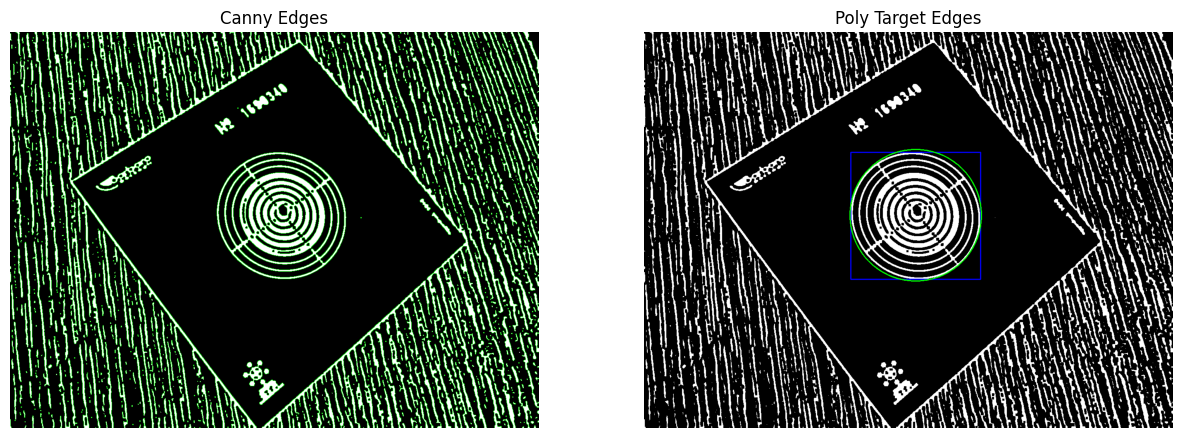

In [118]:
# Canny code
edgeresult = np.copy(cleaned_binary)    # Creating an image copy to draw edges on
edgeresult = cv2.cvtColor(edgeresult, cv2.COLOR_GRAY2BGR)   # Converting it to grayscale for canny detection

th1, th2 = 30, 120  # Canny recommends threshold 2 is 3 times threshold 1
edges = cv2.Canny(cleaned_binary, th1, th2)
edgeresult[edges != 0] = (0, 255, 0)  # Highlight edges: takes pixels in edgeresult and where edge is non-zero it is coloured with green


# Bounding box code
# Find the bigger contour assuming it's the outer circle of the target
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Obtain the bounding box contours and the biggest circle contour by choosing the contours enclosing the largest area
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)      # x:top left, y:bottom right, w:base width, h:height
(xc, yc), radius = cv2.minEnclosingCircle(max_contour)
center = (int(xc), int(yc))
radius = int(radius)

# Another image copy to draw on
bounding_rect = np.copy(cleaned_binary)
bounding_rect = cv2.cvtColor(bounding_rect, cv2.COLOR_GRAY2BGR)

# Draw the bounding box on the target in blue and the outer circle edge in green
drawing = cv2.rectangle(bounding_rect, (x, y), (x + w, y + h), (255, 0, 0), 2)
drawing = cv2.circle(drawing, center, radius, (0, 255, 0), 2)


plt.subplot(121)
plt.title("Canny Edges")
plt.imshow(cv2.cvtColor(edgeresult, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Poly Target Edges")
plt.imshow(cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Transform Perspective
Dinamically correct perspective of the input target. We define the target standardization we'll use to better define the classification intervals for each shot. We use the two functions getPerspectiveTransform() and warpPerspective() to compute and apply the matrix for the tranformation.

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

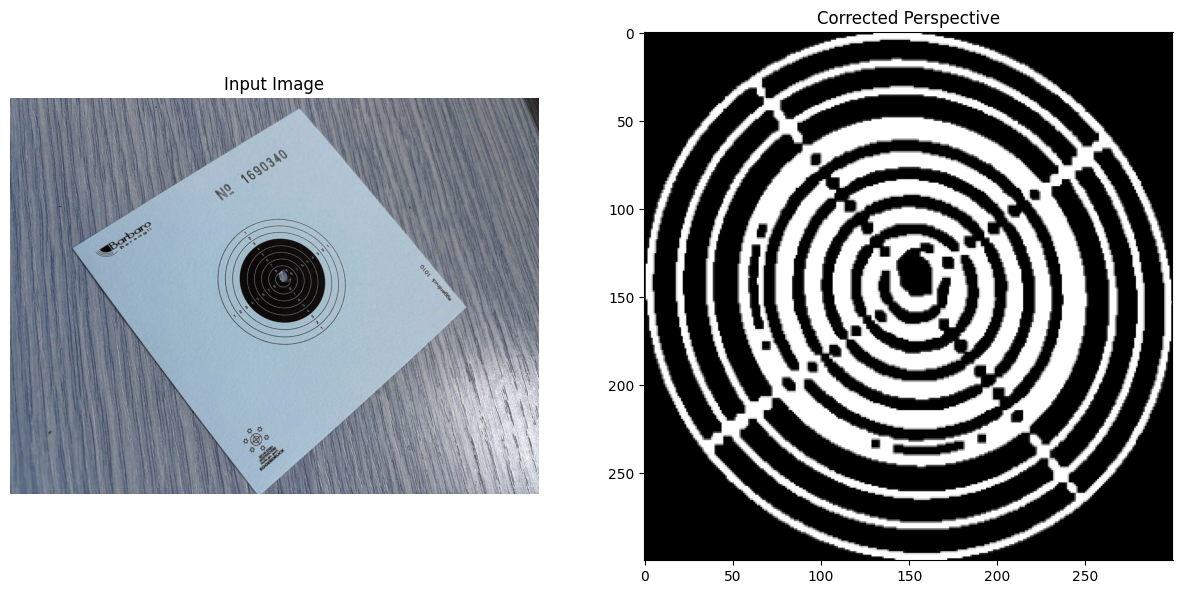

In [119]:
warp_image = np.copy(cleaned_binary)

rect = np.float32([[x, y], [x + w, y],      #Top left, top right
    [x, y + h], [x + w, y + h]      # Bottom right, bottom left
    ])

output_size = 300
dst_pts = np.float32([
    [0, 0], [output_size, 0],   # Top left, top right
    [0, output_size],[output_size, output_size]     # Bottom left, top right
])

# Compute perspective transform matrix
perspective_matrix = cv2.getPerspectiveTransform(rect, dst_pts)
#Apply it to the warped image
corrected_perspective_image = cv2.warpPerspective(warp_image, perspective_matrix, (output_size, output_size))


plt.subplot(121)
plt.title("Input Image")
plt.imshow(image)
plt.axis('off')
plt.subplot(122)
plt.title("Corrected Perspective")
plt.imshow(cv2.cvtColor(corrected_perspective_image,cv2.COLOR_BGR2RGB))
plt.axis('on')

## Detect bullet holes
Detect contours again and find the bullet by comparing the areas. We know the bullet caliber is 4.5 mm so the most likely contour area will be the bullet hole.


Expected hit area: 15.9mm, approximately 706.86px
Hit detected | Hole center: (157, 135), area: 666.03px


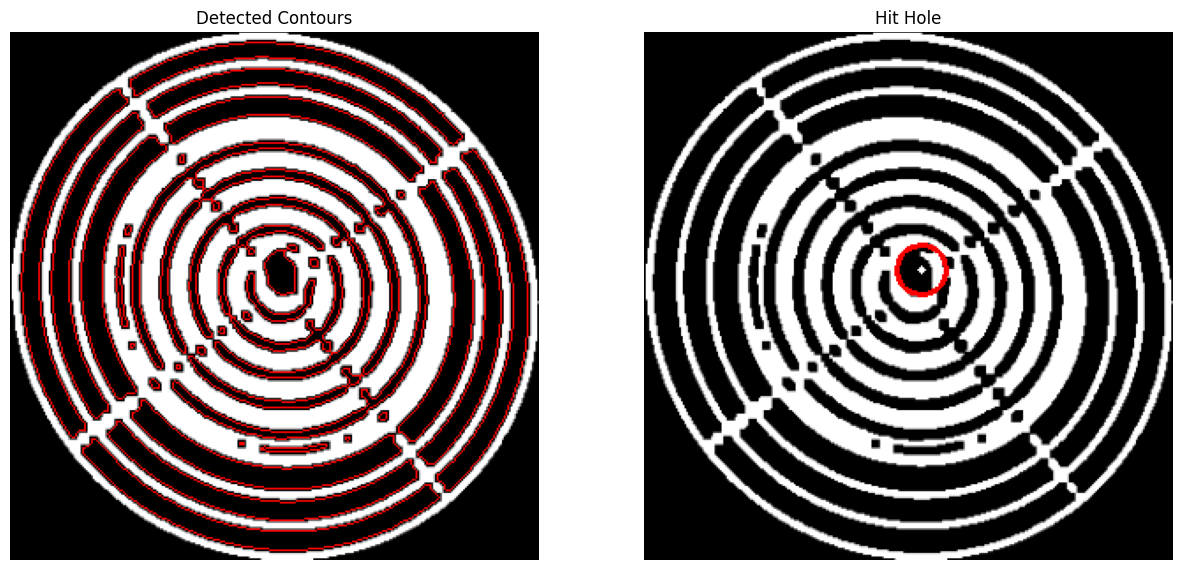

In [120]:
caliber_mm = 4.5
bullet_hole_area_mm = np.square((caliber_mm/2)) * np.pi
# 300 : (22.5mm*2) = x : 1mm -> pixels per mm = 300 / 45
pixels_per_mm = 300/45
expected_area_px = bullet_hole_area_mm * (pixels_per_mm ** 2)

print(f"Expected hit area: {np.round(bullet_hole_area_mm,2)}mm, approximately {expected_area_px:.2f}px")


# New preprocessing to improve the hit detection
blurred = cv2.GaussianBlur(corrected_perspective_image, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


best_contour = None
min_diff = float('inf')
bullet_edgeresult = cv2.cvtColor(corrected_perspective_image, cv2.COLOR_GRAY2BGR)

for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    area_px = np.pi * (radius ** 2)

    # Exclude areas too close to the borders
    x, y, w, h = cv2.boundingRect(contour)
    if x < 5 or y < 5 or x + w > output_size - 5 or y + h > output_size - 5:
        continue

    # If the area is in the tolerance interval, check if it's the closest to the expected dimension
    if 0.2 * expected_area_px < area_px < expected_area_px * 1.3:
        diff = abs(area_px - expected_area_px)
        if diff < min_diff:
            min_diff = diff
            best_contour = contour

    # Visualize all contours
    bullet_edgeresult = cv2.drawContours(bullet_edgeresult, [contour], -1, (0, 0, 255), 1)

# Visualize the detected hit
hit_img = cv2.cvtColor(corrected_perspective_image, cv2.COLOR_GRAY2BGR)
if best_contour is not None:
    (x, y), radius = cv2.minEnclosingCircle(best_contour)
    hit_center = (int(x), int(y))
    hit_img = cv2.circle(hit_img, hit_center, int(radius), (0, 0, 255), 2)
    hit_img = cv2.circle(hit_img, hit_center, 2, (255, 255, 255), -1)
    print(f"Hit detected | Hole center: {hit_center}, area: {np.square(radius)*np.pi:.2f}px")
else:
    print("No hits detected")

plt.subplot(121)
plt.title("Detected Contours")
plt.imshow(cv2.cvtColor(bullet_edgeresult, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Hit Hole")
plt.imshow(cv2.cvtColor(hit_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Assign score
We previously defined the standard for the target by warping the image perspective, so we can now use it to assign the scores in an easier and more precise way. The target center will always be positioned in `(150, 150)` and the ring radii width will remain the same in each image, even the distorted ones. All the dimensions used are defined by the ISSF's official rules, so the rings will have radii of [0.0mm, 2.25mm, 5.0mm, ..., 22.5mm].

In [121]:
target_center = (150, 150)
max_score = 10
target_radius_mm = 22.5  # Total target radius
ring_width_mm = target_radius_mm/max_score  # Width of each ring in millimeters
ring_radii_px = [(i * ring_width_mm) * pixels_per_mm for i in range(1, max_score + 1)]      # Array of widths of each ring in pixels

# Computation of bullet - bullseye distance in pixels
dx = hit_center[0] - target_center[0]
dy = hit_center[1] - target_center[1]
distance_px = np.sqrt(dx**2 + dy**2)

# Compare radii with distance and choose the correct ring to assign score
score = 0
for i, radius in enumerate(ring_radii_px):
    if distance_px <= radius:
        score = max_score - i
        break

print(f"Score: {score} (distance from bullseye: {distance_px:.2f}px)")

Score: 9 (distance from bullseye: 16.55px)


We also compute the score in the decimal notation. According to the ISSF's standards, each ring is divided in 10 subsections with a value of 0.1, so the final score is in the range 0.0 to 10.9.

In [122]:
max_score_decimal = 10.9
decimal_ring_width_mm = ring_width_mm/10  # Width of decimal subsections

# Radial intervals for decimal scores [0.0mm, 0.225, 0.450, ..., 22.5mm] → 109 intervals
decimal_radii_mm = [i * decimal_ring_width_mm for i in range(110)]
decimal_radii_px = [r * pixels_per_mm for r in decimal_radii_mm]

# Computation of bullet - bullseye distance
dx = hit_center[0] - target_center[0]
dy = hit_center[1] - target_center[1]
distance_px = np.sqrt(dx**2 + dy**2)

# Compare radii with distance and choose the correct ring to assign score
score = 0.0
for i, radius in enumerate(decimal_radii_px):
    if distance_px <= radius:
        score = max_score_decimal - (i * 0.1)
        break

print(f"Score: {score:.1f} (distance from bullseye: {distance_px:.2f}px)")


Score: 9.7 (distance from bullseye: 16.55px)
